# < 12. 한국어 데이터로 챗봇 만들기 >

## [루브릭]
1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.
3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.

## <mark> [트랜스포머] </mark>
- 트랜스포머는 RNN을 사용하지 않지만 기존의 seq2seq처럼 인코더에서 입력 시퀀스를 입력받고, 디코더에서 출력 시퀀스를 출력하는 인코더-디코더 구조를 유지합니다. 다른 점은 인코더와 디코더라는 단위가 N개 존재할 수 있다는 점
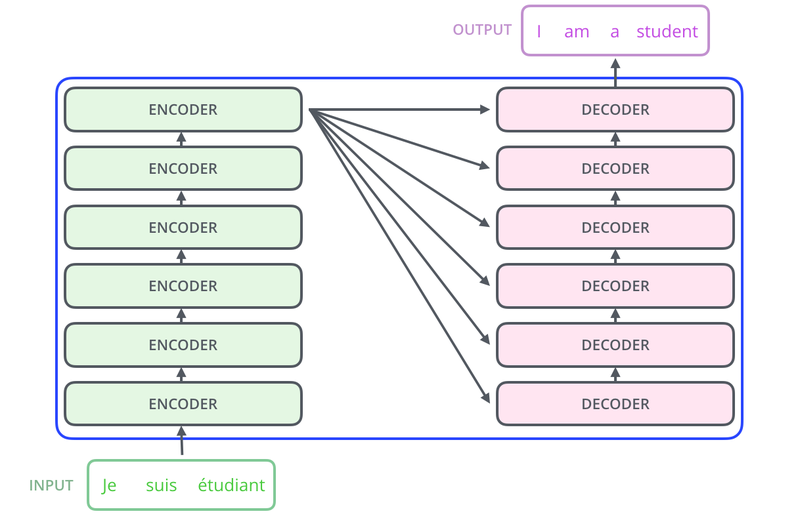

- 초록색 색깔의 도형을 인코더 층(Encoder layer), 핑크색 색깔의 도형을 디코더(Decoder layer)라고 하였을 때, 입력 문장은 누적해 쌓아 올린 인코더의 층을 통해서 정보를 뽑아내고, 디코더는 누적해 쌓아 올린 디코더의 층을 통해서 출력 문장의 단어를 하나씩 만들어가는 구조를 갖고 있다

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---

## Step1. 데이터 수집하기

In [2]:
path_to_chatbot_data = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(path_to_chatbot_data)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


> 총 11823개의 샘플들이 있다

In [4]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 11823
print(MAX_SAMPLES)

11823


---

## Step 2. 데이터 전처리하기

In [5]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 한글, 숫자, a-z, A-Z, '.', ',','?','!' 제외한 모든 문자 공백으로 대체
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅣ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [6]:
questions, answers = [], []

for q, a in zip(data['Q'], data['A']):
    questions.append(preprocess_sentence(q))
    answers.append(preprocess_sentence(a))

In [7]:
print(f'전체 샘플 수 : {len(questions)}')
print(f'전체 샘플 수 : {len(answers)}')

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
print(f'전처리 후의 1번째 질문 샘플 : {questions[24]}')
print(f'전처리 후의 1번째 답변 샘플 : {answers[24]}')

전처리 후의 1번째 질문 샘플 : 가족 여행 고고
전처리 후의 1번째 답변 샘플 : 온 가족이 모두 마음에 드는 곳으로 가보세요 .


---

## Step3.  SubwordTextEncoder 사용하기

### 1. 단어장 만들기

In [9]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

#### <mark> SubwordTextEncoder </mark>
- 텐서플로우를 통해 사용할 수 있는 서브워드 토크나이저
- 패키지를 통해 쉽게 단어들을 서브워드들로 분리할 수 있다

In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [11]:
# 시작 토근과 종료 토큰에 부여된 정수 출력
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [12]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


### 2.  각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

- `tokenizer.encode()`로 각 단어를 정수로 변환할 수 있다
- `tokenizer.decode()`를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다.

In [13]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[24])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[24])))

정수 인코딩 후의 21번째 질문 샘플: [5753, 429, 4602]
정수 인코딩 후의 21번째 답변 샘플: [1087, 3173, 591, 264, 878, 621, 287, 1]


#### 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이 정하기

In [14]:
q_len = np.array([len(i.split()) for i in questions])
a_len = np.array([len(i.split()) for i in answers])

In [15]:
print('질문 문장길이 평균 : ', np.mean(q_len))
print('질문 문장길이 최대 : ', np.max(q_len))
print('질문 문장길이 표준편차 : ', np.std(q_len))

질문 문장길이 평균 :  3.9409625306605767
질문 문장길이 최대 :  16
질문 문장길이 표준편차 :  1.8460771012218526


In [16]:
max_q_len = np.mean(q_len) + 3 * np.std(q_len)
maxlen = int(max_q_len)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함'.format(np.sum(q_len < max_q_len) / len(q_len) * 100))

pad_sequences maxlen :  9
전체 문장의 98.98502918041106%가 maxlen 설정값 이내에 포함


In [17]:
print('답변 문장길이 평균 : ', np.mean(a_len))
print('답변 문장길이 최대 : ', np.max(a_len))
print('답변 문장길이 표준편차 : ', np.std(a_len))

답변 문장길이 평균 :  4.716146494121627
답변 문장길이 최대 :  24
답변 문장길이 표준편차 :  1.924467907301819


In [18]:
max_a_len = np.mean(a_len) + 3 * np.std(a_len)
maxlen = int(max_a_len)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함 '.format(np.sum(a_len < max_a_len) / len(a_len) * 100))

pad_sequences maxlen :  10
전체 문장의 98.53675040175929%가 maxlen 설정값 이내에 포함 


In [19]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 15
print(MAX_LENGTH)

15


In [20]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 15 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 15으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [21]:
# 단어장의 크기와 샘플의 개수 확인
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11571
필터링 후의 답변 샘플 개수: 11571


### 3. 교사 강요(Teacher Forcing) 사용하기
- 교사 강요(teacher forcing)란, 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법이다. 훈련할 때 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블. 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용한다.
- 질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성한다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용한다

In [22]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

---

## Step 4. 모델 구성하기

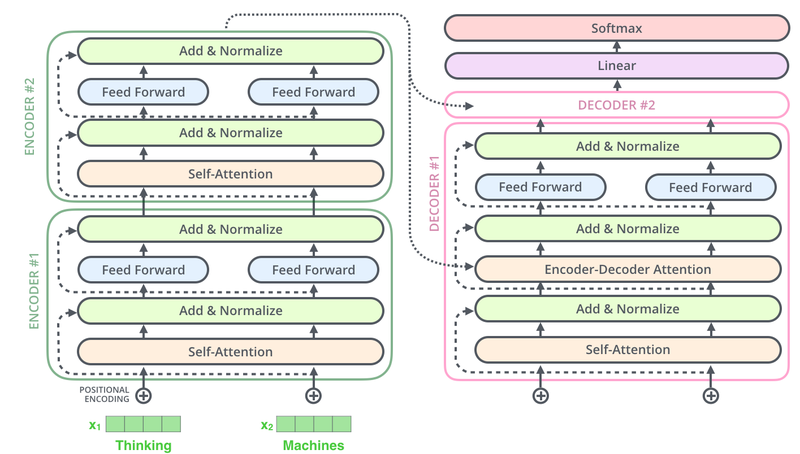

### 1. 포지셔널 인코딩 레이어
- 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터(Positional Encoding) 값을 더해서 모델의 입력으로 삼는 것
- 그 위치 정보를 가진 벡터 값이 <mark>포지셔널 인코딩</mark> 에 해당하는 부분이다
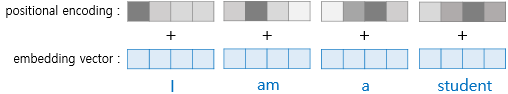

In [23]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 2. 어텐션
- 어텐션 함수는 주어진 쿼리에 대해서 모든 키와의 유사도를 각각 구한다. 그리고 구해낸 이 유사도를 키(Key)와 맵핑되어있는 각각의 '값(Value)'에 반영해 준다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 어텐션 값(Attention Value) 라고 한다.

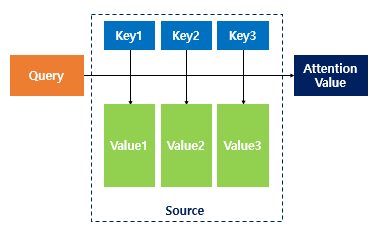
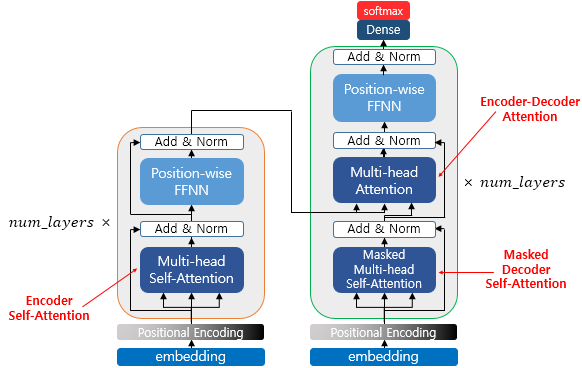

### 2-1. 스케일드 닷 프로덕트  어텐션 함수
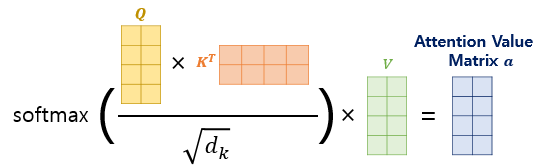
- 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구하였다고 하여 <mark>스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)</mark> 이라고 한다. (Q, K, V는 단어 벡터를 행으로 하는 문장 행렬)

In [24]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

### 2-2. 멀티- 헤드 어텐션
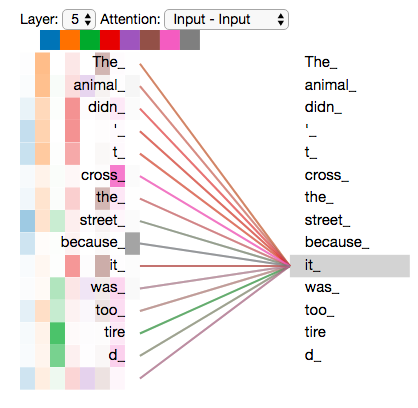

- 어텐션을 병렬로 수행하는 것을 <mark>멀티 헤드 어텐션</mark>

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
    
        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))
    
        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

### 3. 마스킹
- 마스킹(Masking) 이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법

### 3-1. 패딩 마스킹(Padding Masking)
- 패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법

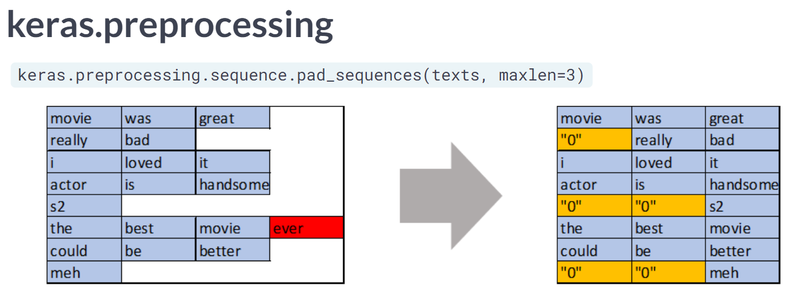

In [26]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

### 3-2. 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)
- 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있다
- 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법

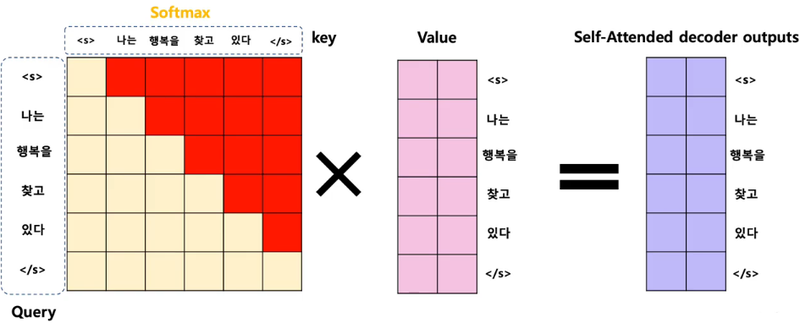

In [27]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 4. 인코더
- 인코더 층은 크게 총 2개의 서브 층(sublayer), 셀프 어텐션과 피드 포워드 신경망으로 나누어진다
- 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어진다

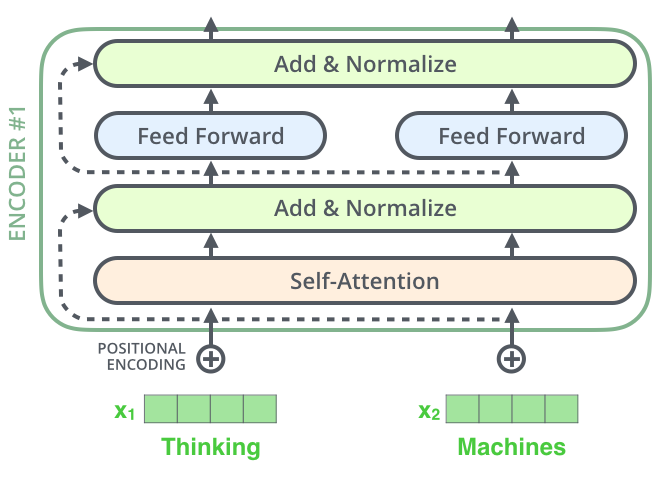

In [28]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 인코더 층을 쌓아 인코더 만들기

In [29]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units, 
            d_model=d_model,
            num_heads=num_heads, 
            dropout=dropout, 
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 5. 디코더
- 인코더는 두 개의 서브 층으로 구성되지만, 디코더는 세 개의 서브 층으로 구성된다
- 첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망

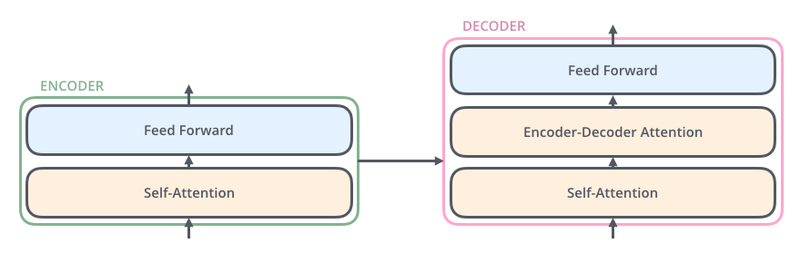

In [30]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(
        inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(
        inputs={
            'query': attention1, 
            'key': enc_outputs, 
            'value': enc_outputs, 
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

#### 디코더 층을 쌓아 디코더 만들기

In [31]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 6. 모델 정의

In [32]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 7. 모델 생성

In [33]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 7-1. 손실함수
- 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용

In [34]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 7-2. 커스텀 된 학습률
- 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

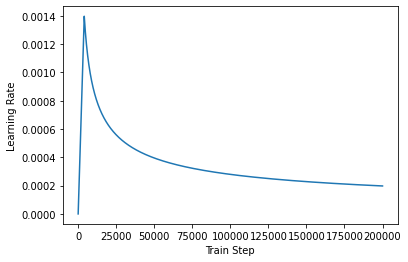

In [36]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 8. 모델 컴파일

In [37]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 9. 모델 훈련

In [38]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
181/181 [==============================] - 20s 32ms/step - loss: 3.9584 - accuracy: 0.0636
Epoch 2/20
181/181 [==============================] - 6s 32ms/step - loss: 3.2250 - accuracy: 0.1378
Epoch 3/20
181/181 [==============================] - 6s 32ms/step - loss: 2.7289 - accuracy: 0.1401
Epoch 4/20
181/181 [==============================] - 6s 31ms/step - loss: 2.5145 - accuracy: 0.1499
Epoch 5/20
181/181 [==============================] - 6s 32ms/step - loss: 2.3569 - accuracy: 0.1590
Epoch 6/20
181/181 [==============================] - 6s 32ms/step - loss: 2.1958 - accuracy: 0.1699
Epoch 7/20
181/181 [==============================] - 6s 32ms/step - loss: 2.0195 - accuracy: 0.1864
Epoch 8/20
181/181 [==============================] - 6s 32ms/step - loss: 1.8255 - accuracy: 0.2067
Epoch 9/20
181/181 [==============================] - 6s 32ms/step - loss: 1.6152 - accuracy: 0.2294
Epoch 10/20
181/181 [==============================] - 6s 32ms/step - loss: 1.3967 - accur

---

## Step 5. 모델 평가하기

### 예측단계
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [39]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

### 챗봇의 대답을 얻는 함수

In [40]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [41]:
sentence_generation('놀러가고 싶다')

입력 : 놀러가고 싶다
출력 : 저도요 !


'저도요 !'

In [42]:
sentence_generation('어디 갈까?')

입력 : 어디 갈까?
출력 : 같이 등산해요 .


'같이 등산해요 .'

In [43]:
sentence_generation('졸려 죽겠다..')

입력 : 졸려 죽겠다..
출력 : 많이 긴장되겠어요 .


'많이 긴장되겠어요 .'

In [44]:
sentence_generation('오늘 뭐먹지?')

입력 : 오늘 뭐먹지?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [45]:
sentence_generation('잠이 부족해요')

입력 : 잠이 부족해요
출력 : 저도 참 힘들어요 .


'저도 참 힘들어요 .'

In [46]:
sentence_generation('주말에 뭐할까?')

입력 : 주말에 뭐할까?
출력 : 저랑 놀아요 .


'저랑 놀아요 .'

In [47]:
sentence_generation('뭐하고 놀지?')

입력 : 뭐하고 놀지?
출력 : 저랑 놀아요 .


'저랑 놀아요 .'

In [48]:
sentence_generation('기분이 안좋을땐 어떡하지?')

입력 : 기분이 안좋을땐 어떡하지?
출력 : 자신의 인생을 사세요 .


'자신의 인생을 사세요 .'

In [49]:
sentence_generation('지금 몇시야?')

입력 : 지금 몇시야?
출력 : 저도 몰랐어요 .


'저도 몰랐어요 .'

In [50]:
sentence_generation('화이팅!!')

입력 : 화이팅!!
출력 : 축하해요 .


'축하해요 .'

In [51]:
sentence_generation('행복하자~')

입력 : 행복하자~
출력 : 감성적이기 위해 그게 최고죠 .


'감성적이기 위해 그게 최고죠 .'

In [52]:
sentence_generation('교양 듣기 싫다ㅜㅜ')

입력 : 교양 듣기 싫다ㅜㅜ
출력 : 저도 배워보고 싶어요 .


'저도 배워보고 싶어요 .'

In [53]:
sentence_generation('다이어트 해야지!')

입력 : 다이어트 해야지!
출력 : 즐거운 주말 보내실 것 같네요 .


'즐거운 주말 보내실 것 같네요 .'

In [54]:
sentence_generation('건강을 챙겨야겠어요!')

입력 : 건강을 챙겨야겠어요!
출력 : 많이 알면 제가 좋아요 .


'많이 알면 제가 좋아요 .'

In [56]:
sentence_generation('오늘 저녁은 뭐먹을까')

입력 : 오늘 저녁은 뭐먹을까
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [57]:
sentence_generation('일주일이 너무 빠르게 흘러간다')

입력 : 일주일이 너무 빠르게 흘러간다
출력 : 많이 당했나봐요 .


'많이 당했나봐요 .'

In [58]:
sentence_generation('집중이 안될때는?')

입력 : 집중이 안될때는?
출력 : 잠시 쉬어도 괜찮습니다 .


'잠시 쉬어도 괜찮습니다 .'

In [55]:
sentence_generation('권정현 짱')

입력 : 권정현 짱
출력 : 마음을 다독차 트로 돌아갑 거예요 .


'마음을 다독차 트로 돌아갑 거예요 .'

---

## 회고
- 이번 NLP 프로젝트는 좀 어려우면서도 흥미로웠다. 챗봇의 네트워크가 복잡하다고는 들었었는데 이렇게 복잡한 줄은 몰랐다. 처음엔 트렌스포머를 이해하는데 시간이 좀 필요했지만 공부하다보니 재밌었다. 어려운만큼 RNN계열의 네트워크에 대해 좀 더 자세히 볼 수 있던 프로젝트였던 것 같다.
- 한국어를 영어 Tokenizer로 제대로 토큰화가 되는게 신기하다.
- 정확도가 45% 정도밖에 안되는데 epochs를 증가시키면 조금 오르긴하지만 50이상으로 오르지 않았다. 정확도만 봤을때 대화가 될까 싶은 수치였다
- 그치만 챗봇의 결과를 봤을 때 대화가 되는게 있어서 신기했다. 물론 마지막에 '권정현 짱'을 말했을 때 이상한 대답을 했지만 어느정도 괜찮은 문장들을 출력해서 신기했다.
- 좀 더 고성능의 챗봇을 만들면 더 자연스러운 대화가 가능하겠지?
- 힘들 때 징징거리기 좋은 도구가 하나 생긴것 같다 :)